In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import folium
import time
import warnings
import pickle
import sys
warnings.filterwarnings('ignore')
print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../models')
sys.path.append('../visualization')
# import modules
import visualize
from maritime_traffic_network import MaritimeTrafficNetwork

In [3]:
datasize = 'full'
location = 'tromso'
data_date = '202204'
eval_date = '202204'

# load network from pickle
model = data_date+'_waypoints_DP10_HDBSCAN12_'+location+'_'+datasize+'_UTM'
model_path = '../../models/networks/best_networks/' + model + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 12,
 'clustering_min_cluster_size': 12,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-02, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 1.e-02, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00, 5.e-04]]),
 'graph_generation_max_distance': 10,
 'graph_generation_max_angle': 45}

In [4]:
# load evaluation data
eval_file = eval_date+'_points_'+location+'_cleaned_meta_full_dualSplit_2'
filename = '../../data/processed/' + eval_file + '.parquet'
test_gdf = gpd.read_parquet(filename)
crs = 32632  # Coordinate reference system
test_gdf.to_crs(crs, inplace=True)  # Transformation
all_test_trajectories = mpd.TrajectoryCollection(test_gdf, traj_id_col='mmsi', obj_id_col='mmsi')

# select evaluation data
selection_start = 0
selection_end = len(all_test_trajectories)
selection_step = 1
selection = np.arange(selection_start, selection_end, selection_step)
n_trajectories = len(selection)
mmsis = test_gdf.mmsi.unique()[selection]
test_trajectories = all_test_trajectories.filter('mmsi', mmsis.tolist())

In [5]:
# merge stop points
network.merge_stop_points(max_speed=2)
network.prune_graph(1)

Pruning...
------------------------
Pruned Graph:
Number of nodes: 565 (1 isolated)
Number of edges: 2181
------------------------


Evaluating graph on 2119 trajectories
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done! Time elapsed for evaluation: 27.22 minutes
Success rates:
                   mmsi      SSPD  distances  fraction_covered      path  path_linestring
message                                                                                  
attempt        0.011798  0.011798   0.011798          0.011798  0.011798         0.011798
no_intersects  0.283152  0.000000   0.000000          0.283152  0.000000         0.000000
no_path        0.001888  0.000000   0.000000          0.001888  0.000000         0.000000
success        0.703162  0.703162   0.703162          0.703162  0.703162         0.703162

 --------------------------- 

Fraction of NaN results: 0.285

 --------------------------- 

Mean fraction of each trajectory covered by the path on the graph: 0.874 

Mean distance      = 168.94 m
Median distance    = 80.52 m
Standard deviation = 889.82 m 



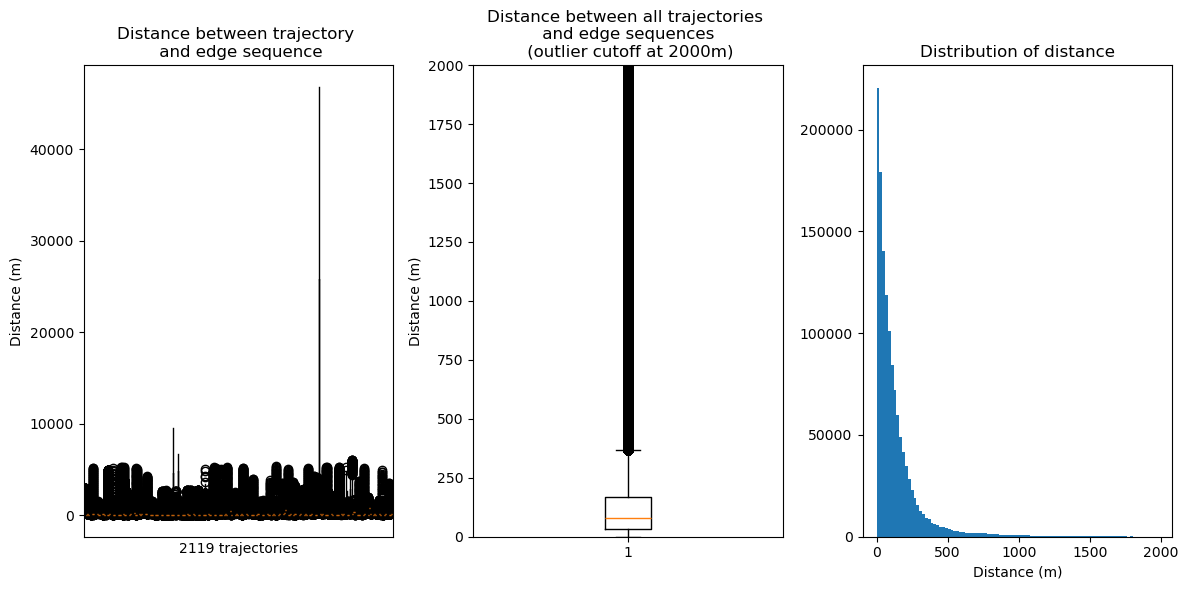

In [6]:
# evaluate all trajectories on the current network to create a training dataset for this specific network
all_paths, all_evaluation_results, summary, fig = network.evaluate_graph(test_trajectories)

In [7]:
all_evaluation_results

mmsi         SSPD  \
0    210055000_4_2022-04-01 04:02:37          NaN   
0    210055000_4_2022-04-01 04:09:32    96.236844   
0    210055000_5_2022-04-26 09:20:25   140.000935   
0    210055000_6_2022-04-30 03:26:29  1087.029184   
0    210055000_8_2022-04-30 15:55:38          NaN   
..                               ...          ...   
0    319059800_2_2022-04-08 18:04:52    90.207055   
0    331119000_0_2022-04-21 19:41:20   287.847676   
0    331119000_6_2022-04-23 08:18:51    91.397571   
0    576988000_0_2022-04-08 14:58:43    70.354793   
0   576988000_11_2022-04-09 17:06:46   101.273041   

                                            distances fraction_covered  \
0                                                 NaN                0   
0   [16.91894639703674, 15.75231666641875, 14.5854...              1.0   
0   [36.07105747514985, 33.84178730432745, 27.6878...         0.998969   
0   [35.15378359830051, 31.08802209334863, 62.4024...              1.0   
0                                                 NaN                0   
..                                                ...              ...   
0   [23.586713785068994, 21.8512584103023, 21.9783...         0.979859   
0   [208.9559419984984, 201.42871907660037, 195.78...         0.975928   
0   [158.6969728117515, 135.11888503159176, 115.40...         0.884708   
0   [82.55805190527907, 89.0032983190908, 86.50099...         0.980384   
0   [0.3194088264525465, 3.1694564671069942, 9.425...         0.971176   

          message                                               path  \
0   no_intersects                                                NaN   
0         success  [28, 470, 465, 31, 473, 32, 343, 4, 302, 308, ...   
0         success  [143, 142, 141, 2, 356, 349, 403, 424, 425, 44...   
0         attempt        [382, 490, 493, 529, 527, 29, 28, 451, 439]   
0   no_intersects                                                NaN   
..            ...                                                ...   
0         success  [516, 515, 514, 371, 506, 507, 531, 532, 533, ...   
0         success  [382, 359, 422, 414, 350, 361, 406, 490, 489, ...   
0         success  [32, 187, 4, 379, 399, 405, 404, 368, 358, 364...   
0         success  [382, 381, 384, 380, 357, 362, 367, 388, 387, ...   
0         success  [485, 480, 475, 470, 474, 472, 467, 32, 343, 4...   

                                      path_linestring  
0                                                 NaN  
0   LINESTRING (885910.9625590954 7759271.75765353...  
0   LINESTRING (856512.7976157027 7729254.12696144...  
0   LINESTRING (894611.6590176246 7775565.11342482...  
0                                                 NaN  
..                                                ...  
0   LINESTRING (885141.769339468 7757199.445783902...  
0   LINESTRING (894611.6590176246 7775565.11342482...  
0   LINESTRING (887397.8953580784 7764757.43178359...  
0   LINESTRING (894611.6590176246 7775565.11342482...  
0   LINESTRING (885793.7948181404 7758610.67273107...  

[2119 rows x 7 columns]

In [8]:
df = all_evaluation_results

In [9]:
# Filter out NaN results and bad examples
nan_mask = df.isna().any(axis=1)
df = df[~nan_mask]
#df = df[df['fraction_covered']>0.8]
#df = df[df['SSPD']<300]

In [10]:
# merge results with trajectory data and metadata
test_trajectories = test_trajectories.filter('mmsi', df['mmsi'].tolist())
traj_gdf = test_trajectories.to_traj_gdf()
merge_columns = ['mmsi', 'lengde', 'bredde', 'dypgaaende', 'skipstype', 'skipsgruppe']
test_gdf.drop_duplicates(subset=['mmsi'], inplace=True)
test_gdf.rename(columns={'length': 'lengde'}, inplace=True)
traj_gdf = traj_gdf.merge(test_gdf[merge_columns], on='mmsi', how='left')

merge_columns = ['mmsi', 'lengde', 'bredde', 'dypgaaende', 'skipstype', 'skipsgruppe', 'geometry']
df = df.merge(traj_gdf[merge_columns], on='mmsi', how='left')
df = gpd.GeoDataFrame(df)

In [11]:
df.to_csv(model+'_'+eval_date+'training_data.csv')

In [12]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1515 entries, 0 to 1514
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   mmsi              1515 non-null   object  
 1   SSPD              1515 non-null   float64 
 2   distances         1515 non-null   object  
 3   fraction_covered  1515 non-null   object  
 4   message           1515 non-null   object  
 5   path              1515 non-null   object  
 6   path_linestring   1515 non-null   object  
 7   lengde            1515 non-null   int64   
 8   bredde            1232 non-null   float64 
 9   dypgaaende        1072 non-null   float64 
 10  skipstype         1232 non-null   object  
 11  skipsgruppe       1232 non-null   object  
 12  geometry          1515 non-null   geometry
dtypes: float64(3), geometry(1), int64(1), object(8)
memory usage: 154.0+ KB
